In [1]:
%matplotlib inline
import re
import string
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import sys
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [2]:
dataset_unprocessed = pd.read_csv('../Datasets/combined_dataset_all.csv', 
                                                 encoding = "ISO-8859-1", dtype={"split": "string", "message": "string", "genre": "string"})

In [3]:
# converting any 0 to 2 (translates to no)
dataset= dataset_unprocessed.replace(2,0)

In [4]:
dataset.head(10)

,split,message,genre,related,PII,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,train,Weather update - a cold front from Cuba that c...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,train,Is the Hurricane over or is it not over,direct,1,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,train,"says: west side of Haiti, rest of the country ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,train,Storm at sacred heart of jesus,direct,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,train,"Please, we need tents and water. We are in Sil...",direct,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,train,"There's nothing to eat and water, we starving ...",direct,1,0,1,0,1,1,1,...,0,1,1,1,0,0,0,0,0,1
6,train,"I am in Thomassin number 32, in the area named...",direct,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
7,train,"Let's do it together, need food in Delma 75, i...",direct,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,train,More information on the 4636 number in order f...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,train,"A Comitee in Delmas 19, Rue ( street ) Janvier...",direct,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


In [5]:
dataset.shape

(38263, 40)

In [6]:
dataset['genre'].unique()

<StringArray>
['direct', 'social', 'news']
Length: 3, dtype: string

In [7]:
dataset['related'].value_counts()

1    20928
0    17335
Name: related, dtype: int64

In [8]:
dataset['genre'].value_counts()

social    19241
news      11090
direct     7932
Name: genre, dtype: Int64

In [9]:
dataset.dtypes

split                     string
message                   string
genre                     string
related                    int64
PII                        int64
request                    int64
offer                      int64
aid_related                int64
medical_help               int64
medical_products           int64
search_and_rescue          int64
security                   int64
military                   int64
child_alone                int64
water                      int64
food                       int64
shelter                    int64
clothing                   int64
money                      int64
missing_people             int64
refugees                   int64
death                      int64
other_aid                  int64
infrastructure_related     int64
transport                  int64
buildings                  int64
electricity                int64
tools                      int64
hospitals                  int64
shops                      int64
aid_center

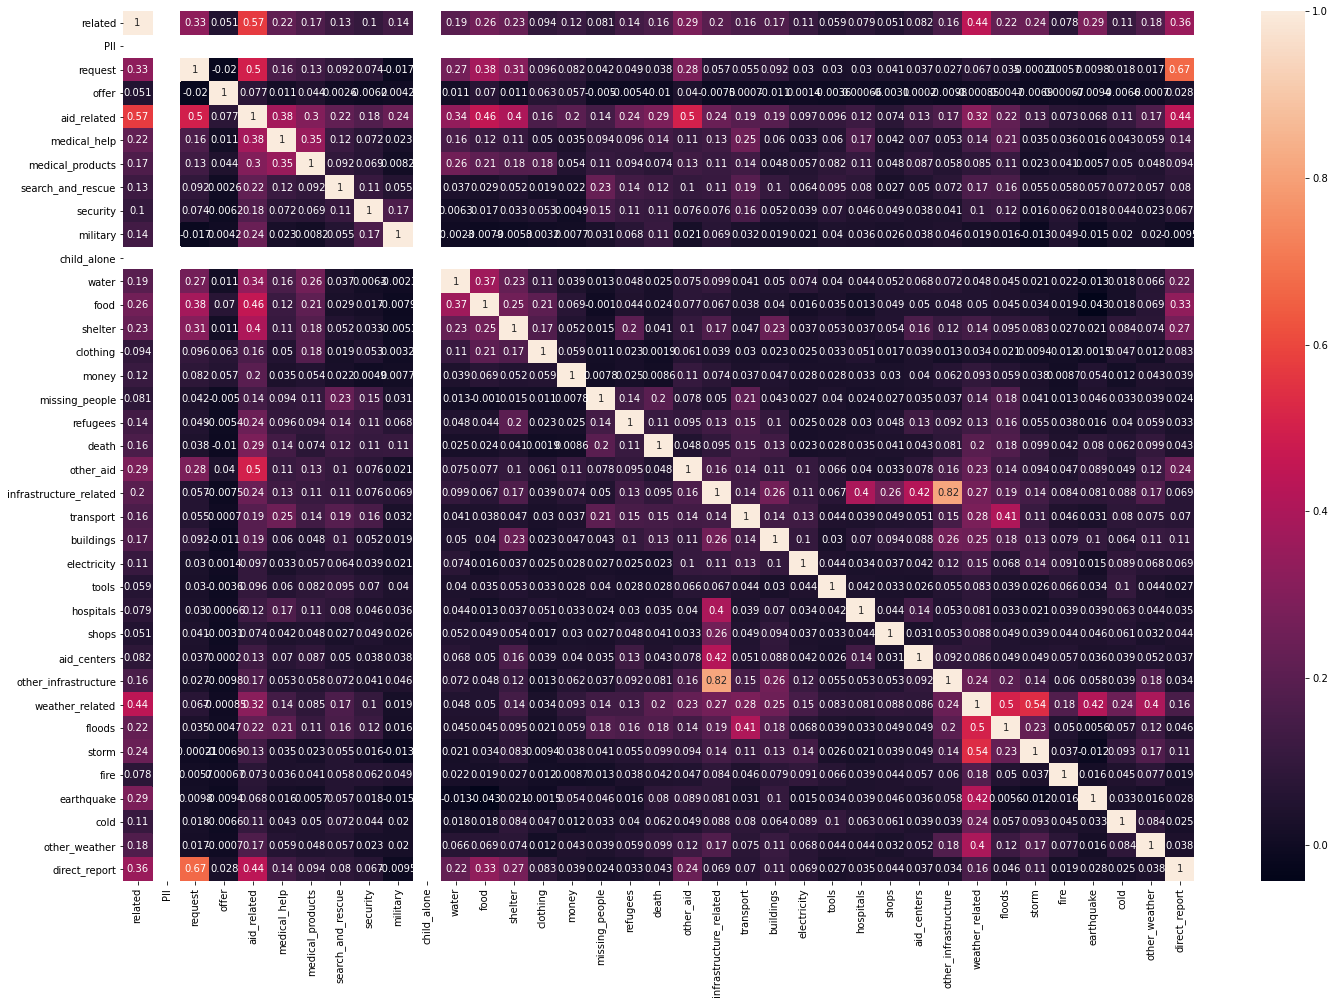

In [10]:
# use high correlations to identfiy tags that can be removed
dataset_corr = dataset.corr()
fig, ax = plt.subplots(figsize=(24,16))

sns.heatmap(dataset_corr, annot=True)

In [11]:
# minimising the dataset for R&I
dataset.drop(dataset.columns.difference(['message', 'related', 'cold','earthquake', 'fire', 'storm', 'medical_help','water','food','shelter','electricity','missing_people','infrastructure_related','hospitals']), 1, inplace=True)

In [12]:
dataset.sample(5)

,message,related,medical_help,water,food,shelter,missing_people,infrastructure_related,electricity,hospitals,storm,fire,earthquake,cold
680,"people together in area the area is Carrefour,...",1,0,1,1,0,0,0,0,0,0,0,0,0
11846,Important agriculture implements such as power...,1,0,0,0,0,0,0,0,0,0,0,0,0
35995,"I am in Leogane, I would like to know the pric...",0,0,0,0,0,0,0,0,0,0,0,0,0
17565,off to town. forgot to charge my phone so don'...,0,0,0,0,0,0,0,0,0,0,0,0,0
36201,they poorly distributing the helps because onl...,1,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
# Identifying the number of comments in each category (disaster related & weather related)
dr_tags = dataset.drop(['message'], axis=1)
counts = []
categories = list(dr_tags.columns.values)
for i in categories:
    #if (categories == 1):
    counts.append((i, dr_tags[i].sum()))
dr_tags_stats = pd.DataFrame(counts, columns=['category', 'number_of_messages'])

In [14]:
# number of comments in each category
dr_tags_stats

,category,number_of_messages
0,related,20928
1,medical_help,2087
2,water,1674
3,food,2930
4,shelter,2319
5,missing_people,299
6,infrastructure_related,1705
7,electricity,534
8,hospitals,283
9,storm,2448


In [15]:
# total number of rows in each category (about 1/4 are weather related and 3/4 are disaster related)
dr_tags.count()

related                   38263
medical_help              38263
water                     38263
food                      38263
shelter                   38263
missing_people            38263
infrastructure_related    38263
electricity               38263
hospitals                 38263
storm                     38263
fire                      38263
earthquake                38263
cold                      38263
dtype: int64

Text(0.5, 0, 'category')

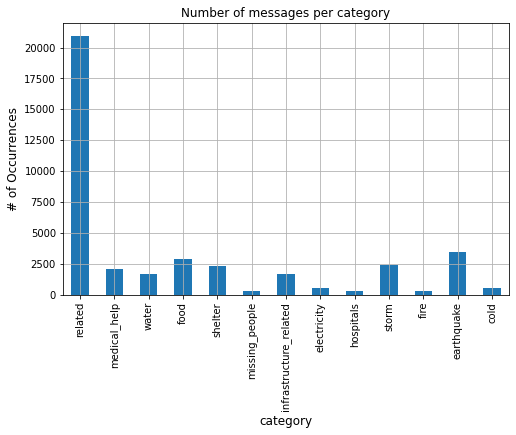

In [16]:
# visualising the categories
dr_tags_stats.plot(x='category', y='number_of_messages', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of messages per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of categories')

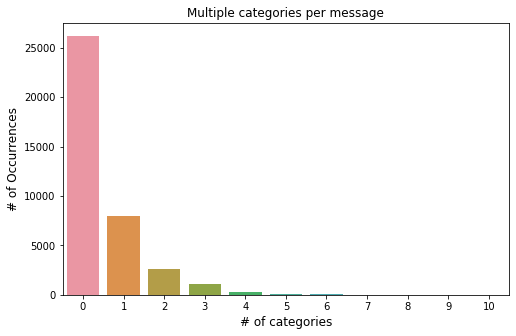

In [17]:
# How many comments have multi labels?
rowsums = dataset.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per message")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

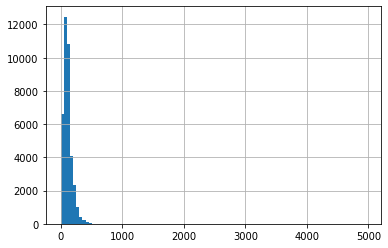

In [18]:
# distribution of the number of words: nothing above 600
lens = dataset.message.str.len()
lens.hist(bins = np.arange(0,5000,50))
# ylabel = number of messages'
# xlabel = number of characters'

In [19]:
print('Number of missing messages in message text:')
dataset['message'].isnull().sum()

Number of missing messages in message text:


0

In [20]:
# minimising the dataset further ready for model training
dataset.drop(dataset.columns.difference(['message', 'related']), 1, inplace=True)

In [21]:
dataset.sample(5)

,message,related
16199,@CaitlinOConnor i want tacos and margarhitas ...,0
26008,"Ugh, I hate working Saturdays! That makes 45h...",0
6437,RT bcworld: #Chile's president calls for calm ...,1
26591,On my way 2 work. Raining here in k.c guess m...,0
37952,"For its part, the government has pulled out th...",0


In [22]:
# having apeek at the first message
dataset['message'][0]

'Weather update - a cold front from Cuba that could pass over Haiti'

In [23]:
# function to clean the data
def clean_text(text):
    # make all text lowercase
    text = text.lower()
    # substitute common abbreviations
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    # removes any leading spaces at the beginning and trailing spaces at the end
    text = text.strip(' ')
    # new bit
    # remove punctuations
    words = text.split()
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in words]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    # stemming of words
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in words]
    seperator = " "
    text = seperator.join(words)
#     print(words)
#     print("---")
    return text

In [24]:
dataset['message'] = dataset['message'].map(lambda com : clean_text(com))
# dataset['message'][0]

In [25]:
categories = ['related']
train, test = train_test_split(dataset, random_state=42, test_size=0.10, shuffle=True)
X_train = train.message
X_test = test.message
y_train = train.related
y_test = test.related
predictionsArray = np.array([])
targetValuesArray = np.array([])
print(X_train.shape)
print(X_test.shape)

(34436,)
(3827,)


In [26]:
# adding all the test data to an array used for classification report
# for index, row in dr_test_dataset.iterrows():
#     recordValuesArray = [row.related, row.cold, row.earthquake, row.fire, row.storm, row.medical_help, row.water, row.food, row.shelter, row.electricity, row.missing_people, row.infrastructure_related, row.hospitals]
#     targetValuesArray.append(recordValuesArray)

for column in test[['related']]:
    columnSeriesObj = test[column]
    targetValuesArray = np.append(targetValuesArray, columnSeriesObj.values)

In [27]:
# Define a pipeline combining a text feature extractor with multi label classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', LogisticRegression()),
            ])
# print accuracy for each label
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    predictionsArray = np.append(predictionsArray, prediction)
    print('Test accuracy is {}'.format('%.2f' % accuracy_score(test[category], prediction)))

... Processing related
Test accuracy is 0.93


In [28]:
# view predictions and true values arrays
print("Predictions")
print(np.shape(predictionsArray))
print(" ")
# for x in predictionsArray:
#     print(x) 
print(" ")
print("True Values")
print(np.shape(targetValuesArray))
print(" ")
# for x in targetValuesArray:
#     print(x) 

Predictions
(3827,)
 
 
True Values
(3827,)
 


In [29]:
# print a classification report for each label
# for i in range(len(categories)):
#     print("Classification Report for '" + categories[i] + "' category:")
#     print(" ")
#     print(classification_report(targetValuesList[i], predictionsList[i], zero_division= 1, target_names = [categories[i] + " negative", categories[i] + " positive"]))

In [30]:
# print classification report to get overall model stats
print(classification_report(targetValuesArray, predictionsArray, zero_division= 1, target_names = ['Unrelated', 'Related']))

              precision    recall  f1-score   support

   Unrelated       0.94      0.92      0.93      1755
     Related       0.93      0.95      0.94      2072

    accuracy                           0.93      3827
   macro avg       0.93      0.93      0.93      3827
weighted avg       0.93      0.93      0.93      3827



In [31]:
# calculating pipeline size in bytes
p = pickle.dumps(NB_pipeline)
print(sys.getsizeof(p))

2482787


In [32]:
# confusion matrix expressing True & False Ratios 
pd.DataFrame(confusion_matrix(targetValuesArray, predictionsArray), columns=['Predicted Related', "Predicted Non-Related"], index=['Actual Related', 'Actual Non-Related'])

,Predicted Related,Predicted Non-Related
Actual Related,1607,148
Actual Non-Related,110,1962


In [33]:
tn, fp, fn, tp = confusion_matrix(targetValuesArray, predictionsArray).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 1962
False Positives: 148
True Negatives: 1607
False Negatives: 110


In [34]:
# selecting probabilities for only the positive class (related)
probas = NB_pipeline.predict_proba(X_test)[:, 1]

In [35]:
# function to convert predictions according to various threshold rates.
def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]

In [36]:
# create a list of True Positive Rates and False Positive Rates at varying threshold rates
roc_values = []
for thresh in np.linspace(0, 1, 100):
    preds = get_preds(thresh, probas)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    tpr = tp/(tp+fn)
    fpr = fp/(fp+tn)
    roc_values.append([tpr, fpr])
tpr_values, fpr_values = zip(*roc_values)

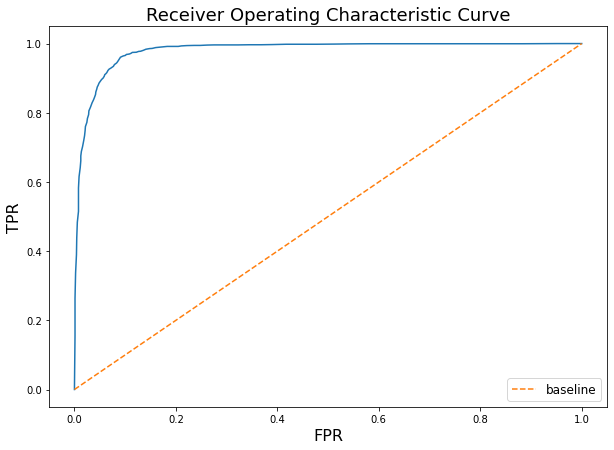

In [38]:
# plot results as ROC Curve
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(fpr_values, tpr_values)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=18)
plt.ylabel('TPR', fontsize=16)
plt.xlabel('FPR', fontsize=16)
plt.legend(fontsize=12);

In [39]:
# calculating AUC score
fpr, tpr, thresholds = roc_curve(targetValuesArray, predictionsArray, pos_label=1)
AUC = auc(fpr, tpr)
AUC

0.9312903562903563